# Step 1 : Importing Essetial Libraries


In [9]:
# pip install neptune-tensorflow-keras

# pip install np_utils
# pip install keras==2.0.6
# conda install keras
# pip install tensorflow

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
# from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [10]:
print(keras.__version__)

2.13.1


# Step 2 : Importing Data and Creating a Dataframe


In [9]:
import os
import pandas as pd

train_dir = r'D:\KU data\BigData_Public Administration\BigData_PowerPoint\BigData\CNN\cancer_data\train'
test_dir = r'D:\KU data\BigData_Public Administration\BigData_PowerPoint\BigData\CNN\cancer_data\test'

# Create dataframes
train_df = pd.DataFrame(columns=['image_path', 'label'])
test_df = pd.DataFrame(columns=['image_path', 'label'])

# Add images paths and labels to dataframes
for label, directory in enumerate(os.listdir(train_dir)):
    for filename in os.listdir(os.path.join(train_dir, directory)):
        image_path = os.path.join(train_dir, directory, filename)
        train_df = train_df.append({'image_path': image_path, 'label': label}, ignore_index=True)

for label, directory in enumerate(os.listdir(test_dir)):
    for filename in os.listdir(os.path.join(test_dir, directory)):
        image_path = os.path.join(test_dir, directory, filename)
        test_df = test_df.append({'image_path': image_path, 'label': label}, ignore_index=True)
        
# Combine train_df and test_df into one dataframe
df = pd.concat([train_df, test_df], ignore_index=True)
del test_df,train_df
df

C:\Users\Taechatuch\AppData\Local\Temp\ipykernel_1632\452321679.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'image_path': image_path, 'label': label}, ignore_index=True)
C:\Users\Taechatuch\AppData\Local\Temp\ipykernel_1632\452321679.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'image_path': image_path, 'label': label}, ignore_index=True)
C:\Users\Taechatuch\AppData\Local\Temp\ipykernel_1632\452321679.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'image_path': image_path, 'label': label}, ignore_index=True)
C:\Users\Taechatuch\AppData\Local\Temp\ipykernel_1632\452321679.py:15: FutureWarning: The frame.append method is

,image_path,label
0,D:\KU data\BigData_Public Administration\BigDa...,0
1,D:\KU data\BigData_Public Administration\BigDa...,0
2,D:\KU data\BigData_Public Administration\BigDa...,0
3,D:\KU data\BigData_Public Administration\BigDa...,0
4,D:\KU data\BigData_Public Administration\BigDa...,0
...,...,...
3292,D:\KU data\BigData_Public Administration\BigDa...,1
3293,D:\KU data\BigData_Public Administration\BigDa...,1
3294,D:\KU data\BigData_Public Administration\BigDa...,1
3295,D:\KU data\BigData_Public Administration\BigDa...,1


In [10]:
# Get list of directories in train_dir
labels = os.listdir(train_dir)

# Create label_map dictionary
label_map = {i: label for i, label in enumerate(labels)}
num_classes=len(label_map)
label_map

{0: 'benign', 1: 'malignant'}

# Step 3 : EDA


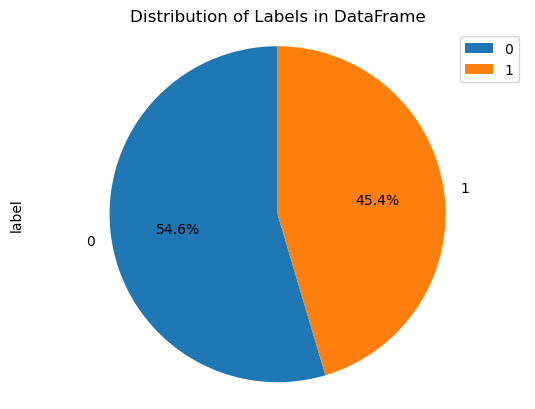

In [11]:
# Plot pie chart of train_df
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['label'].unique())
plt.show()

In [12]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               benign                         1800      
1               malignant                      1497      
------------------------------------------------------------
Total                                         3297      


# Step 4 : Loading and resizing of images


In [13]:
max_images_per_class = 2500

# Group by label column and take first max_images_per_class rows for each group
df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)

C:\Users\Taechatuch\AppData\Local\Temp\ipykernel_1632\3886418994.py:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)


In [14]:
import tensorflow as tf

# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[]


In [15]:
import multiprocessing

# Get the number of CPU cores available
max_workers = multiprocessing.cpu_count()
max_workers

4

In [16]:
import concurrent.futures

# Define a function to resize image arrays
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((100,75)))

# Use concurrent.futures to parallelize the resizing process
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Use executor.map to apply the function to each image path in the DataFrame
    image_arrays = list(executor.map(resize_image_array, df['image_path'].tolist()))

# Add the resized image arrays to the DataFrame
df['image'] = image_arrays
del image_arrays

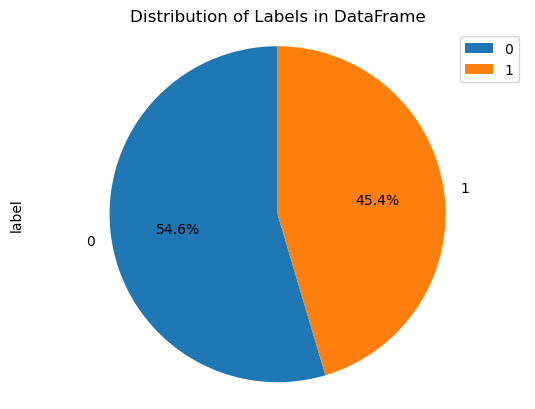

In [17]:
# Plot pie chart of train_df
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['label'].unique())
plt.show()

In [18]:
df.head()

,image_path,label,image
0,D:\KU data\BigData_Public Administration\BigDa...,0,"[[[223, 174, 194], [222, 177, 199], [224, 179,..."
1,D:\KU data\BigData_Public Administration\BigDa...,0,"[[[212, 120, 131], [215, 123, 132], [213, 121,..."
2,D:\KU data\BigData_Public Administration\BigDa...,0,"[[[210, 131, 143], [211, 135, 148], [212, 136,..."
3,D:\KU data\BigData_Public Administration\BigDa...,0,"[[[160, 117, 123], [161, 115, 122], [161, 114,..."
4,D:\KU data\BigData_Public Administration\BigDa...,0,"[[[232, 158, 179], [233, 160, 180], [235, 162,..."


> # Displaying the total number of images of each Class before Data Augmentation


In [19]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               benign                         1800      
1               malignant                      1497      
------------------------------------------------------------
Total                                         3297      


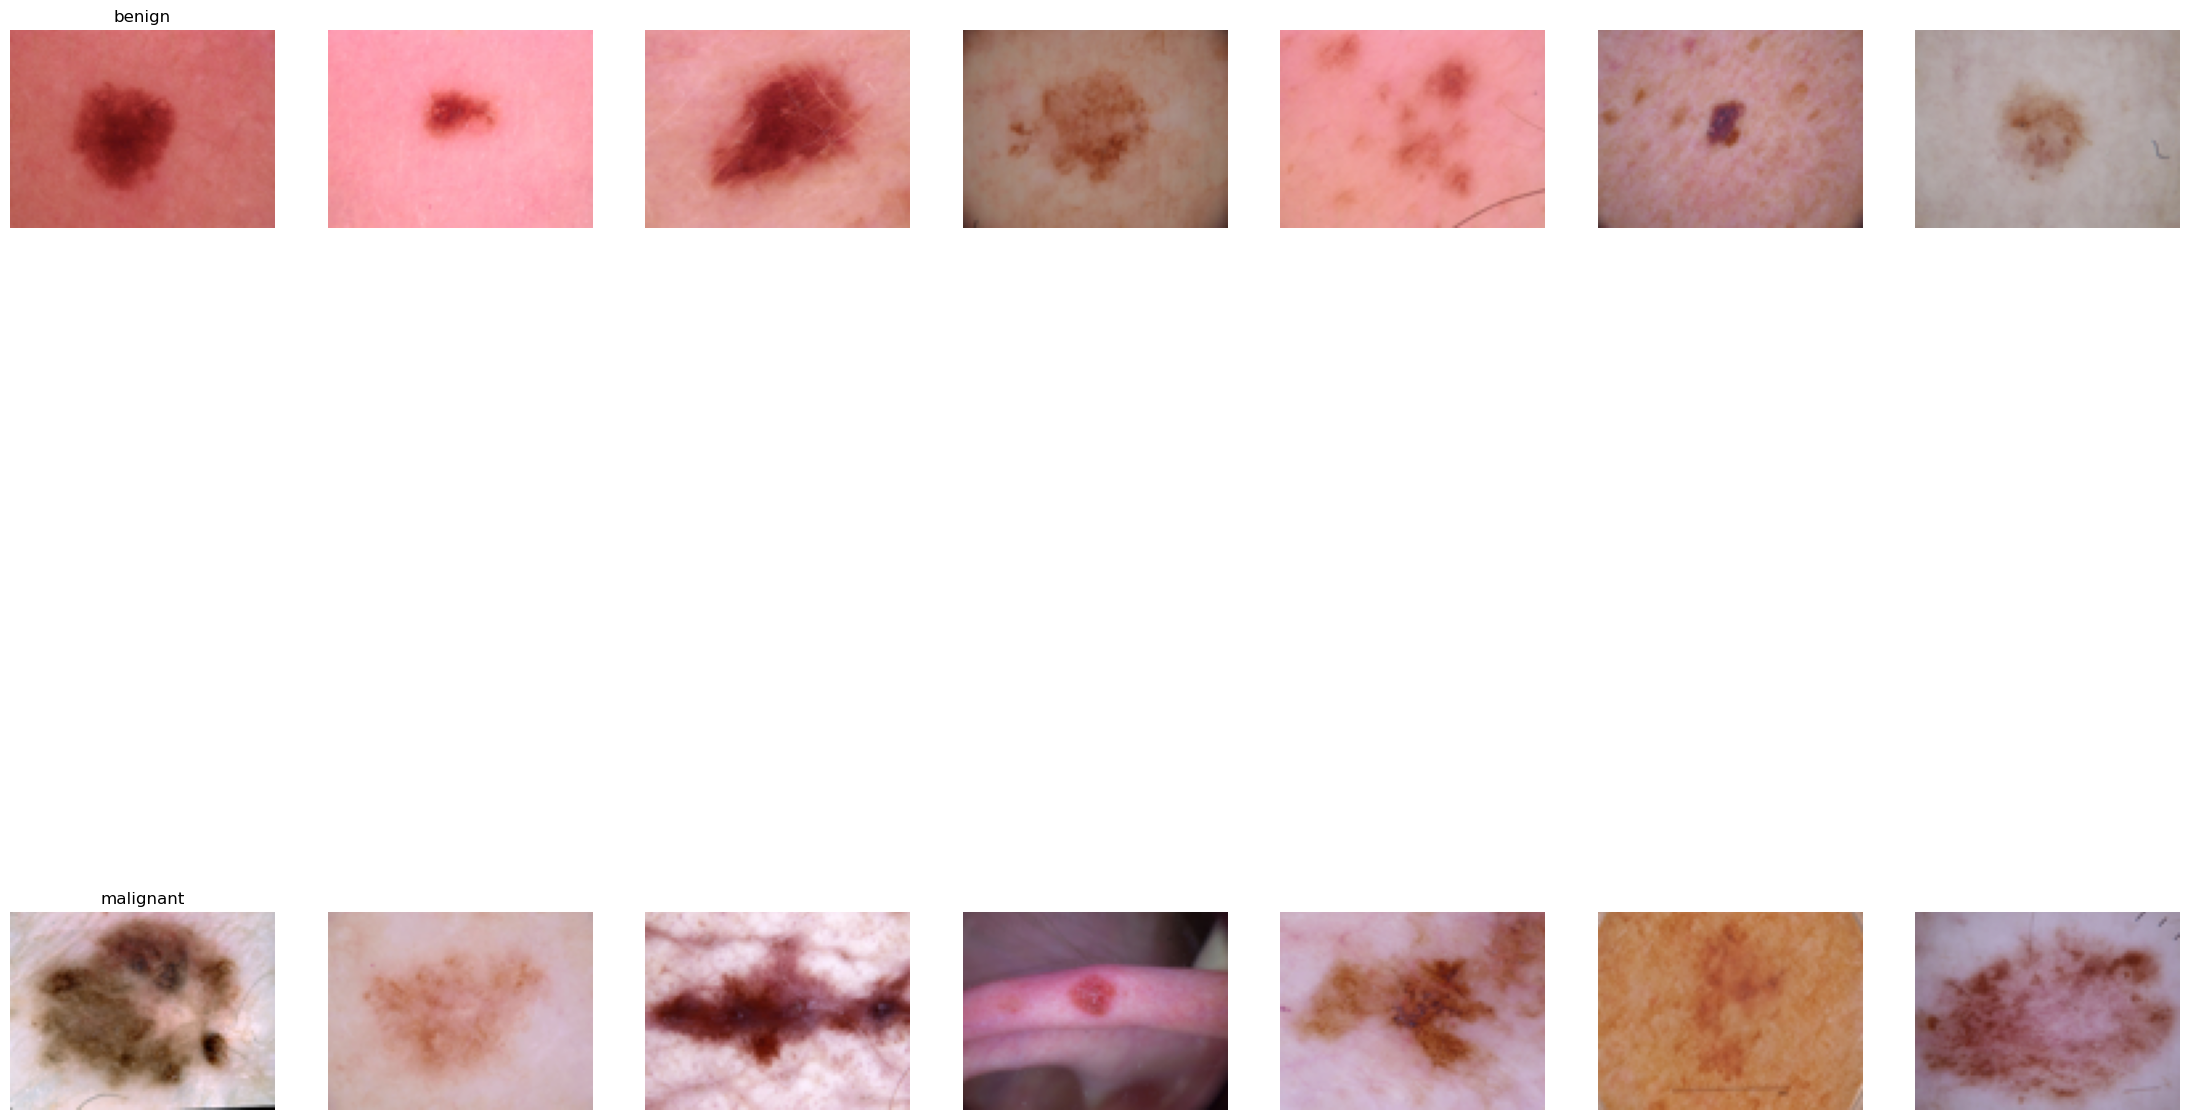

In [20]:
n_samples = 7
fig, m_axs = plt.subplots(num_classes, n_samples, figsize=(4*n_samples, 3*7))
for n_axs, (class_idx, class_rows) in zip(m_axs, df.sort_values(['label']).groupby('label')):
    class_name = label_map[class_idx] # get the class name using label_map
    n_axs[0].set_title(class_name)
    for c_ax, (_, c_row) in zip(n_axs, class_rows.sample(n_samples, random_state=5).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [21]:
df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    3297
Name: image, dtype: int64

# Step 5 : Data Augmentation


In [22]:
from keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object with the desired transformations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [23]:
# Create an empty dataframe to store the augmented images
augmented_df = pd.DataFrame(columns=['image_path', 'label', 'image'])

# Loop through each class label and generate additional images if needed
for class_label in df['label'].unique():
    # Get the image arrays for the current class
    image_arrays = df.loc[df['label'] == class_label, 'image'].values
    
    # Calculate the number of additional images needed for the current class
    num_images_needed = max_images_per_class - len(image_arrays)
    
    # Generate augmented images for the current class
    if num_images_needed > 0:
        # Select a random subset of the original images
        selected_images = np.random.choice(image_arrays, size=num_images_needed)
        
        # Apply transformations to the selected images and add them to the augmented dataframe
        for image_array in selected_images:
            # Reshape the image array to a 4D tensor with a batch size of 1
            image_tensor = np.expand_dims(image_array, axis=0)
            
            # Generate the augmented images
            augmented_images = datagen.flow(image_tensor, batch_size=1)
            
            # Extract the augmented image arrays and add them to the augmented dataframe
            for i in range(augmented_images.n):
                augmented_image_array = augmented_images.next()[0].astype('uint8')
                augmented_df = augmented_df.append({'image_path': None, 'label': class_label, 'image': augmented_image_array}, ignore_index=True)
    
    # Add the original images for the current class to the augmented dataframe
    original_images_df = df.loc[df['label'] == class_label, ['image_path', 'label', 'image']]
    augmented_df = augmented_df.append(original_images_df, ignore_index=True)

# Group the augmented dataframe by the 'label' column and filter out extra images
df = augmented_df.groupby('label').head(max_images_per_class)

del augmented_df

# Use the augmented dataframe for further processing
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

C:\Users\Taechatuch\AppData\Local\Temp\ipykernel_1632\1226775557.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append({'image_path': None, 'label': class_label, 'image': augmented_image_array}, ignore_index=True)
C:\Users\Taechatuch\AppData\Local\Temp\ipykernel_1632\1226775557.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append({'image_path': None, 'label': class_label, 'image': augmented_image_array}, ignore_index=True)
C:\Users\Taechatuch\AppData\Local\Temp\ipykernel_1632\1226775557.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append({'image_path': None, 'label': class_label, 'image': augmented_image_array}, ignore_i

> # Displaying the total number of images of each Class after Data Augmentation


In [24]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               benign                         2500      
1               malignant                      2500      
------------------------------------------------------------
Total                                         5000      


# Step 6 : Train and Test split


In [25]:
features = df.drop(columns=['label','image_path'],axis=1)
target = df['label']

In [26]:
features.head()

,image
0,"[[[201, 157, 207], [208, 159, 210], [203, 151,..."
1,"[[[227, 212, 194], [227, 214, 194], [227, 213,..."
2,"[[[84, 69, 60], [121, 100, 90], [127, 107, 97]..."
3,"[[[202, 137, 149], [202, 137, 147], [206, 139,..."
4,"[[[24, 13, 32], [42, 23, 50], [69, 40, 75], [9..."


In [27]:
target.head()

0    0
1    1
2    1
3    0
4    0
Name: label, dtype: object

In [28]:
print(target.shape,features.shape)

(5000,) (5000, 1)


In [29]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20,shuffle=True)

# Step 7 : Normalization of Data


In [30]:
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# Step 8 : Label Encoding


In [31]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train,num_classes = num_classes)
y_test = to_categorical(y_test,num_classes = num_classes)

# Step 9 : Splitting the data into training and Validation Split


In [32]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2,shuffle=True)

In [33]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [34]:
y_train = y_train.astype(int)
y_validate = y_validate.astype(int)

> # Displaying the total number of images of each Class


In [35]:
# Calculate the number of images in each class for train, validation, and test datasets
train_counts = np.sum(y_train, axis=0)
val_counts = np.sum(y_validate, axis=0)
test_counts = np.sum(y_test, axis=0)

# Print the number of images in each class for train, validation, and test datasets
print("Dataset Summary")
print("-" * 90)
print(f"{'Class Label':<15} {'Class Name':<30} {'Train':<10} {'Validation':<12} {'Test':<10} {'Total':<10}")
print("-" * 90)
for class_label, class_name in label_map.items():
    train_num = int(train_counts[class_label])
    val_num = int(val_counts[class_label])
    test_num = int(test_counts[class_label])
    total_num = train_num + val_num + test_num
    print(f"{class_label:<15} {class_name:<30} {train_num:<10} {val_num:<12} {test_num:<10} {total_num:<10}")
print("-" * 90)
print(f"{'Total':<46} {len(y_train):<10} {len(y_validate):<12} {len(y_test):<10} {len(y_train) + len(y_validate) + len(y_test):<10}")

Dataset Summary
------------------------------------------------------------------------------------------
Class Label     Class Name                     Train      Validation   Test       Total     
------------------------------------------------------------------------------------------
0               benign                         1582       402          516        2500      
1               malignant                      1618       398          484        2500      
------------------------------------------------------------------------------------------
Total                                          3200       800          1000       5000      


In [36]:
df.groupby('label').size()

label
0    2500
1    2500
dtype: int64

In [37]:
input_shape = df['image'][0].shape

# Step 10 : Model Architecture


In [38]:
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# DenseNet201
model = Sequential()
model.add(DenseNet201(include_top=False, weights='imagenet', input_shape=input_shape))
model.add(Flatten())
model.add(Dropout(0.5))  # Add a Dropout layer with a dropout rate of 0.5
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

74836368/74836368 [==============================] - 6s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 2, 3, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dropout (Dropout)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 512)               5898752   
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 24221762 (92.40 MB)
Trainable params: 23992706 (91.52 MB)
Non-trainable params: 229056 (894.75 KB)
__________

# Step 11 : Setting Optimizer


In [39]:
# compile model
from keras.optimizers import SGD
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

# Step 12: Fitting of model


In [40]:
# Fit the model
epochs = 50
batch_size=32
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_validate,y_validate),
                    callbacks=learning_rate_reduction)

Epoch 1/50
100/100 [==============================] - 956s 9s/step - loss: 0.5308 - accuracy: 0.7881 - val_loss: 0.4797 - val_accuracy: 0.8100 - lr: 0.0010
Epoch 2/50
100/100 [==============================] - 779s 8s/step - loss: 0.3192 - accuracy: 0.8600 - val_loss: 0.3056 - val_accuracy: 0.8763 - lr: 0.0010
Epoch 3/50
100/100 [==============================] - 781s 8s/step - loss: 0.1960 - accuracy: 0.9175 - val_loss: 0.3106 - val_accuracy: 0.8700 - lr: 0.0010
Epoch 4/50
100/100 [==============================] - 867s 9s/step - loss: 0.1430 - accuracy: 0.9413 - val_loss: 0.2846 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 5/50
100/100 [==============================] - 1060s 11s/step - loss: 0.0686 - accuracy: 0.9716 - val_loss: 0.3832 - val_accuracy: 0.8775 - lr: 0.0010
Epoch 6/50
100/100 [==============================] - 1261s 13s/step - loss: 0.0479 - accuracy: 0.9850 - val_loss: 0.3164 - val_accuracy: 0.8975 - lr: 0.0010
Epoch 7/50
100/100 [==============================] - 1573s 

# Step 13 : Model Evaluation


In [41]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
print("Train: accuracy = %f  ;  loss = %f" % (accuracy, loss))

100/100 [==============================] - 217s 2s/step - loss: 0.0012 - accuracy: 0.9994
Train: accuracy = 0.999375  ;  loss = 0.001239


In [42]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Testing: accuracy = %f  ;  loss = %f" % (accuracy, loss))

32/32 [==============================] - 59s 2s/step - loss: 0.6941 - accuracy: 0.8900
Testing: accuracy = 0.890000  ;  loss = 0.694059


32/32 [==============================] - 60s 2s/step


<Axes: >

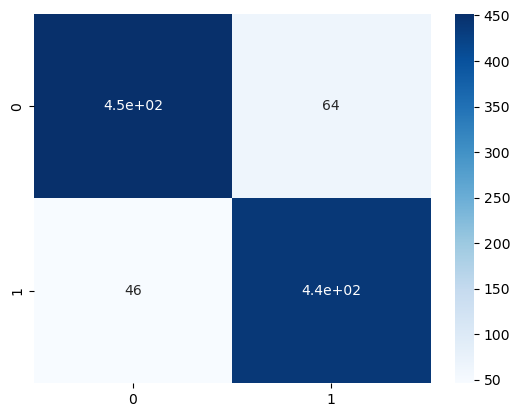

In [43]:
# pip install -U scikit-learn
# pip install seaborn


from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted probabilities for the test set
y_pred_prob = model.predict(x_test)

# Find the class with the highest probability for each sample
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, cmap='Blues')

In [44]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# Calculate evaluation metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='macro')
recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='macro')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='macro')
kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Kappa score: {kappa:.4f}")

Accuracy: 0.8900
Precision: 0.8901
Recall: 0.8905
F1-score: 0.8900
Kappa score: 0.7800


# Step 14 : Saving the model


In [45]:
model.save("skin_cancer_model.h5")

c:\Users\Taechatuch\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
